# Sample Efficiency Dev

This notebook is the development of the sample efficiency experiment.

The rodent dataset can be downloaded via the [following google drive link](https://drive.google.com/file/d/1BHKe9agnupdPC8xExx4OaPtPJBKTTI2U/view).

## Create Dataset w/ Different Sample Sizes and Different Sample Distributions


In [41]:
%load_ext autoreload
%autoreload 2


from typing import Union
import h5py
from jax import numpy as jp
from flax import struct
import yaml
from omegaconf import DictConfig
from pathlib import Path
import hydra
import logging
from track_mjx.io.load import ReferenceClip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
%config InlineBackend.figure_format = 'retina'


def make_multiclip_data(traj_data_path):
    """Creates ReferenceClip object with multiclip tracking data.
    Features have shape = (clips, frames, dims)
    """

    def reshape_frames(arr, clip_len):
        return jp.array(
            arr[()].reshape(arr.shape[0] // clip_len, clip_len, *arr.shape[1:])
        )

    with h5py.File(traj_data_path, "r") as data:
        # Read the config string as yaml in to dict
        yaml_str = data["config"][()]
        yaml_str = yaml_str.decode("utf-8")
        config = yaml.safe_load(yaml_str)
        clip_len = config["stac"]["n_frames_per_clip"]

        # Reshape the data to (clips, frames, dims)
        batch_qpos = reshape_frames(data["qpos"], clip_len)
        batch_xpos = reshape_frames(data["xpos"], clip_len)
        batch_qvel = reshape_frames(data["qvel"], clip_len)
        batch_xquat = reshape_frames(data["xquat"], clip_len)
        return ReferenceClip(
            position=batch_qpos[:, :, :3],
            quaternion=batch_qpos[:, :, 3:7],
            joints=batch_qpos[:, :, 7:],
            body_positions=batch_xpos,
            velocity=batch_qvel[:, :, :3],
            angular_velocity=batch_qvel[:, :, 3:6],
            joints_velocity=batch_qvel[:, :, 6:],
            body_quaternions=batch_xquat,
        )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
stac_data_path = "/root/vast/scott-yang/track-mjx/data/transform_snips.h5"
clips = make_multiclip_data(stac_data_path)

In [43]:
clips.position.shape

(842, 250, 3)

In [44]:
with h5py.File(stac_data_path, "r") as data:
    # Read the config string as yaml in to dict)
    yaml_str = data["config"][()]
    yaml_str = yaml_str.decode("utf-8")
    config = yaml.safe_load(yaml_str)
    clip_len = config["stac"]["n_frames_per_clip"]
    print(f"{clip_len=}")
    print(data["qpos"].shape)

clip_len=250
(210500, 74)


In [45]:
# here is how to get the snips class from data file.
config["model"]["snips_order"]

import re

pattern = re.compile(r"/([^/]+)_([0-9]+)\.p$")
clip_metadata = []
for path in config["model"]["snips_order"]:
    match = pattern.search(path)
    if match:
        name, number = match.groups()
        clip_metadata.append((name, int(number)))

<Axes: title={'center': 'Distribution of clips in the dataset'}, xlabel='Behavioral Category', ylabel='Count'>

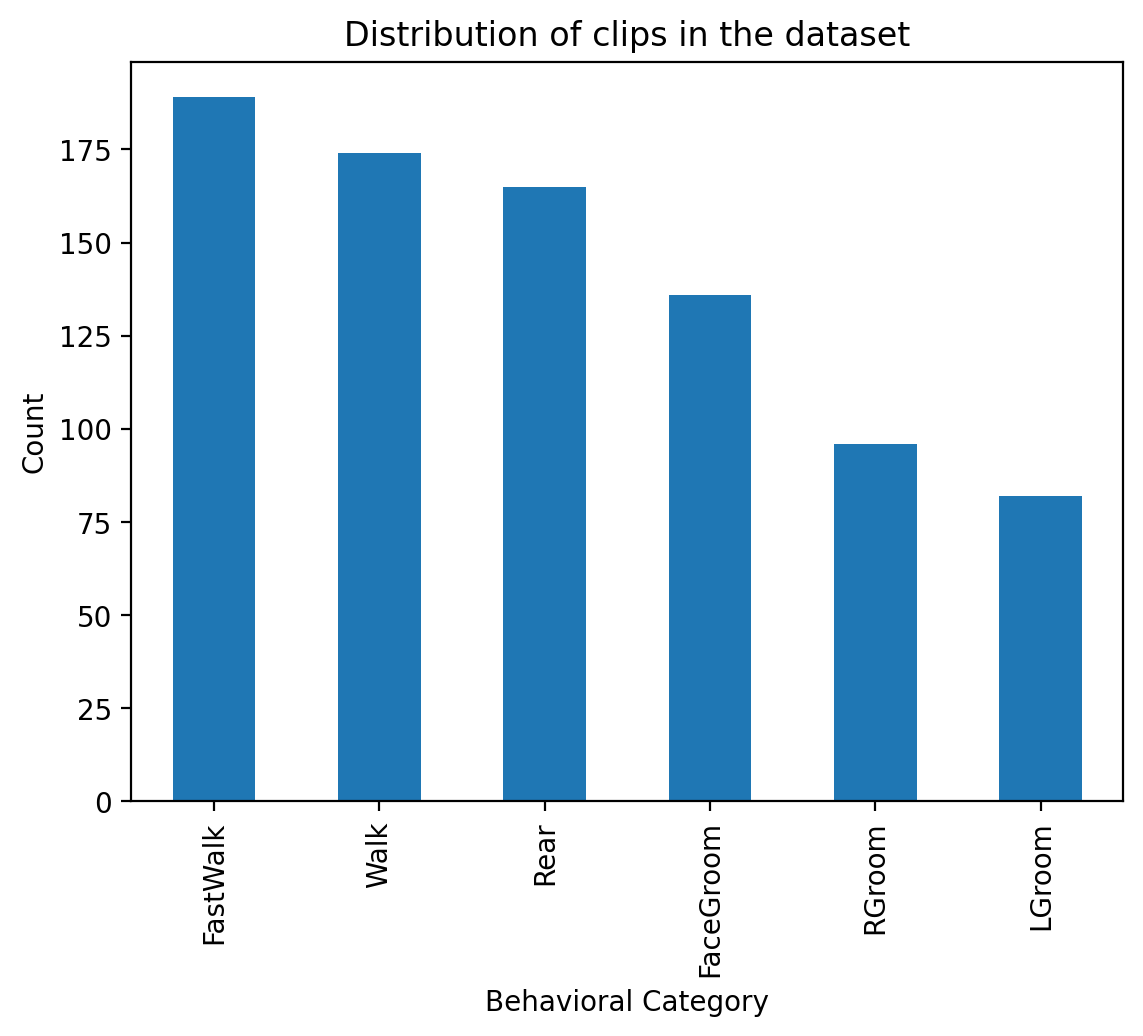

In [46]:
# the following shows the distribution of clips
pd.Series([i[0] for i in clip_metadata]).value_counts().plot(
    kind="bar",
    title="Distribution of clips in the dataset",
    xlabel="Behavioral Category",
    ylabel="Count",
)

To test the sample efficiency of this algorithm, I should design a specific hold out test set to evaluate the performance on. Maybe I should start focusing on a single behavior category and then generalize to more?

### Useful helper function to the splitting better.

In [47]:
def generate_train_test_split(
    clip_metadata: list[tuple[str, int]],
    test_ratio: float = 0.1,
):
    """
    Generates a train-test split of the clips based on the provided ratio.
    The split is done by randomly sampling clips from the metadata list.
    The function returns two ReferenceClip objects: one for training and one for testing.
    """
    indices = np.array((range(len(clip_metadata))))
    test_idx = np.random.choice(
        indices, size=int(len(clip_metadata) * test_ratio), replace=False
    )
    train_idx = indices[~np.isin(indices, test_idx)]
    train_idx.sort()
    test_idx.sort()
    return train_idx, test_idx


def sub_sample_training_set(train_idx: np.ndarray, train_ratio: float = 0.1):
    """
    Given the indices of the training clips, this function randomly samples a subset
    of the training clips based on the provided ratio without replacement.

    Args:
        train_idx (np.ndarray): Array of indices for the training clips.
        train_ratio (float, optional): Ratio of the training clips to sample. Defaults to 0.1.
    """
    sample_size = int(len(train_idx) * train_ratio)
    sampled_idx = np.random.choice(train_idx, size=sample_size, replace=False)
    sampled_idx.sort()
    return sampled_idx


def select_clips(
    clips: ReferenceClip,
    indices: np.ndarray,
) -> ReferenceClip:
    """
    Selects clips from the ReferenceClip object based on the provided indices.
    The function returns a new ReferenceClip object containing only the selected clips.
    """
    selected_clips = ReferenceClip(
        position=clips.position[indices],
        quaternion=clips.quaternion[indices],
        joints=clips.joints[indices],
        body_positions=clips.body_positions[indices],
        velocity=clips.velocity[indices],
        angular_velocity=clips.angular_velocity[indices],
        joints_velocity=clips.joints_velocity[indices],
        body_quaternions=clips.body_quaternions[indices],
        clip_idx=jp.array(indices),
    )
    return selected_clips

In [48]:
train_idx, test_idx = generate_train_test_split(clip_metadata, test_ratio=0.1)
train_clips, test_clips = select_clips(clips, train_idx), select_clips(clips, test_idx)
train_ratios = np.arange(0.1, 1.1, 0.1)
train_subset_indexes = {}
for ratio in train_ratios:
    sampled_train_idx = sub_sample_training_set(train_idx, train_ratio=ratio)
    train_subset_indexes[ratio] = sampled_train_idx

In [ ]:
# serialize the train/test split data to the disk
with open("train_test_split.json", "w") as f:
    json.dump(
        {
            "train": [int(i) for i in train_idx],
            "test": [int(i) for i in test_idx],
            "train_subset": {
                str(ratio): [int(i) for i in sampled_train_idx]
                for ratio, sampled_train_idx in train_subset_indexes.items()
            },
        },
        f,
    )

In [52]:
# load the train/test split data from the disk
with open("train_test_split.json", "r") as f:
    train_test_split = json.load(f)
train_test_split.keys()

dict_keys(['train', 'test', 'train_subset'])